In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
pd.options.mode.chained_assignment = None


In [2]:
# Set the min and max x-values for the cross-section x ranges to compare

CSranges = {'CS1_xmin' : 962193.06, 'CS1_xmax' : 981314.88, 'CS2_xmin' : 957000, \
            'CS2_xmax' : 980570.66, 'CS3_xmin' : 951849.43, 'CS3_xmax' : 967044.74, \
            'CS4_xmin' : 951396.23, 'CS4_xmax' : 966954.96, 'CS5_xmin' : 946919.49, \
            'CS5_xmax' : 975000,    'CS6_xmin' : 955531.35, 'CS6_xmax' : 975284.74, 
            'CS7_xmin' : 944062.6,  'CS7_xmax' : 970779.56
}


In [3]:
# Read in observed isochrones

# This dictionary stores a separate dataframe for each cross-section
radardata = {}
for i in range(1,8):
    radardata['data' + str(i)] = pd.read_csv('../Data/AdjustedRadarStatigraphy/Observed/RadarSegment' + str(i) + '.csv', sep=",")
    # Sort the data so that it is from smallest to largest x
    radardata['data' + str(i)] = radardata['data' + str(i)].sort_values(by='psX')
    radardata['data' + str(i)] = radardata['data' + str(i)].reset_index(drop=True)
    radardata['data' + str(i)]['Dist'] = [0]*len(radardata['data' + str(i)])
    radardata['data' + str(i)]['Base'] = radardata['data' + str(i)]['Surface'] - radardata['data' + str(i)]['base']
#    radardata['data' + str(i)]['xNew'] = [0]*len(radardata['data' + str(i)])
    xinit = radardata['data' + str(i)]['psX'][0]
    yinit = radardata['data' + str(i)]['psY'][0]
    x0, y0 = xinit, yinit
    for j in range(1,len(radardata['data' + str(i)])):
        x0 = radardata['data' + str(i)]['psX'][j-1]
        y0 = radardata['data' + str(i)]['psY'][j-1]
        x1 = radardata['data' + str(i)]['psX'][j]
        y1 = radardata['data' + str(i)]['psY'][j]
        radardata['data' + str(i)]['Dist'][j] = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
#        radardata['data' + str(i)]['xNew'][j] = radardata['data' + str(i)]['xNew'][j-1] \
#                                              + radardata['data' + str(i)]['Dist'][j]
    for j in range(1,13):
        radardata['data' + str(i)]['StratSlope' + str(j)] = [0]*len(radardata['data' + str(i)])
        for k in range(1, len(radardata['data' + str(i)])):
            #x0 = radardata['data' + str(i)]['Dist'][k-1]
            #x1 = radardata['data' + str(i)]['Dist'][k]
            dist = radardata['data' + str(i)]['Dist'][k]
            z0 = radardata['data' + str(i)]['StratElev' + str(j)][k-1]
            z1 = radardata['data' + str(i)]['StratElev' + str(j)][k]
            radardata['data' + str(i)]['StratSlope' + str(j)][k] = (z1 - z0)/dist

    


In [4]:
# Read in modelled isochrones

# This dictionary stores a separate dataframe for each cross-section
modelleddata = {}
ages = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

for i in range(1,8):
    data = pd.read_csv('../Data/AdjustedRadarStatigraphy/BasalFriction2e7Age400Time7500StrainRate/Isochrones' + str(i) + '.csv', sep=",")
    data = data.sort_values(by='Points:0')
    data = data.reset_index(drop=True)
    data['slope'] = [0]*len(data)
    for j in ages:
        df = data.loc[data['age'] == j]
        df['index'] = df.index
        df = df.reset_index(drop=True)
        df['slope'] = [0]*len(df)
        for k in range(1,len(df)):
            dist = np.sqrt((df['Points:1'][k] - df['Points:1'][k-1])**2 + (df['Points:0'][k] - df['Points:0'][k-1])**2)
            if dist != 0:
                df['slope'][k] = (df['Points:2'][k] - df['Points:2'][k-1])/dist
            else:
                df['slope'][k] = df['slope'][k-1]
        df['SlopeSmoothed'] = df['slope'] #.rolling(20).mean()
        for k in range(1,len(df)):
            ind = df['index'][k]
            data['slope'][int(ind)] = df['SlopeSmoothed'][k]
    modelleddata['data' + str(i)] = data
modelleddata['data5']

,age,Points:0,Points:1,Points:2,slope
0,300,942100.0,1926500.0,-208.2700,0.000000
1,100,942100.0,1926500.0,-1.1762,0.000000
2,50,942100.0,1926500.0,19.2230,0.000000
3,200,942100.0,1926500.0,-67.3200,0.000000
4,350,942100.0,1926500.0,-312.0600,0.000000
...,...,...,...,...,...
7595,250,974990.0,1957000.0,62.2600,-0.074675
7596,750,974990.0,1957000.0,23.0100,-0.062567
7597,700,974990.0,1957000.0,26.2760,-0.069367
7598,850,974990.0,1957000.0,16.4780,-0.059158


In [5]:
# Make a polygon for each cross-section using the observational data and the ranges 
# given above

# Need to make two lists: one with the x-values and one with the y-values. 

polys = {}

for i in range(1,8):
    Lowest  = radardata['data' + str(i)]['StratElev12'][(radardata['data' + str(i)]['psX'] > CSranges['CS' + str(i) + '_xmin']) \
                                             & (radardata['data' + str(i)]['psX'] < CSranges['CS' + str(i) + '_xmax'])
                                             & (~radardata['data' + str(i)]['StratElev12'].isnull())].tolist()
    Lowestx = radardata['data' + str(i)]['psX'][(radardata['data' + str(i)]['psX'] > CSranges['CS' + str(i) + '_xmin']) \
                                             & (radardata['data' + str(i)]['psX'] < CSranges['CS' + str(i) + '_xmax'])
                                             & (~radardata['data' + str(i)]['StratElev12'].isnull())].tolist()
    CS1z = radardata['data' + str(i)]['Surface'][(radardata['data' + str(i)]['psX'] > CSranges['CS' + str(i) + '_xmin']) \
                                       & (radardata['data' + str(i)]['psX'] < CSranges['CS' + str(i) + '_xmax'])].tolist() \
                                       + Lowest[::-1]
    CS1x = radardata['data' + str(i)]['psX'][(radardata['data' + str(i)]['psX'] > CSranges['CS' + str(i) + '_xmin']) \
                                       & (radardata['data' + str(i)]['psX'] < CSranges['CS' + str(i) + '_xmax'])].tolist() \
                                       + Lowestx[::-1]
    polys['poly' + str(i)] = Polygon(zip(CS1x, CS1z))


In [6]:
# Make a list of all observed slopes with corresponding x-values

# Need to apply the smoothing to each isochrone rather than over the entire dataset

Slopes = {}
Gridx = {}
Gridz = {}

for i in range(1,8):
    Gridx['grid_x' + str(i)], Gridz['grid_z' + str(i)] = np.mgrid[CSranges['CS' + str(i) + '_xmin']:CSranges['CS' + str(i) + '_xmax']:300j, -150:450:300j]
    X = np.linspace(CSranges['CS' + str(i) + '_xmin'], CSranges['CS' + str(i) + '_xmax'], 300)
    Z = np.linspace(-150, 450, 300)

    lstX = []
    lstZ = []
    lstSlope = []

    for j in range(1,13):
        lstZ = lstZ + radardata['data' + str(i)]['StratElev' + str(j)].tolist()
        lstX = lstX + radardata['data' + str(i)]['psX'].tolist()
        lstSlope = lstSlope + radardata['data' + str(i)]['StratSlope' + str(j)].tolist()
        
    df2 = pd.DataFrame()
    df2['X'] = lstX
    df2['Z'] = lstZ
    df2['Slope'] = lstSlope  

    # Remove all lines with any NaN values
    df2 = df2[df2['Z'].notna()]
    df2 = df2[df2['Slope'].notna()]
    df2['SlopeSmoothed'] = df2['Slope'].rolling(20).mean()
    df2 = df2[df2['SlopeSmoothed'].notna()]

    slopeint = scipy.interpolate.griddata((df2['X'], df2['Z']), df2['SlopeSmoothed'], (Gridx['grid_x' + str(i)], Gridz['grid_z' + str(i)]), method='linear')
    
    for j in range(len(X)):
        for k in range(len(Z)):
            boolean = polys['poly' + str(i)].contains(Point(X[j], Z[k]))
            if boolean == False:
                slopeint[j][k] = np.nan
    
    Slopes['Slope' + str(i)] = slopeint

In [7]:
# Make a list of all modelled slopes with corresponding x-values
# Need to clean this code up once it is working: some code is unnecessary

SlopesMod = {}

for i in range(1,8):
    X = np.linspace(CSranges['CS' + str(i) + '_xmin'], CSranges['CS' + str(i) + '_xmax'], 300)
    Z = np.linspace(-150, 450, 300)

    lstZ = modelleddata['data' + str(i)]['Points:2'].tolist()
    lstX = modelleddata['data' + str(i)]['Points:0'].tolist()
    lstSlope = modelleddata['data' + str(i)]['slope'].tolist()
        
    df2 = pd.DataFrame()
    df2['X'] = lstX
    df2['Z'] = lstZ
    df2['Slope'] = lstSlope

    # Remove all lines with any NaN values
    #df2 = df2[df2['Z'].notna()]
    #df2 = df2[df2['Slope'].notna()]
    df2['SlopeSmoothed'] = df2['Slope'] #.rolling(4).mean()
    #df2 = df2[df2['SlopeSmoothed'].notna()]

    slopeint = scipy.interpolate.griddata((df2['X'], df2['Z']), df2['Slope'], (Gridx['grid_x' + str(i)], Gridz['grid_z' + str(i)]), method='linear')
    
    for j in range(len(X)):
        for k in range(len(Z)):
            boolean = polys['poly' + str(i)].contains(Point(X[j], Z[k]))
            if boolean == False:
                slopeint[j][k] = np.nan
    
    SlopesMod['Slope' + str(i)] = slopeint

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/4028932954.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/4028932954.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


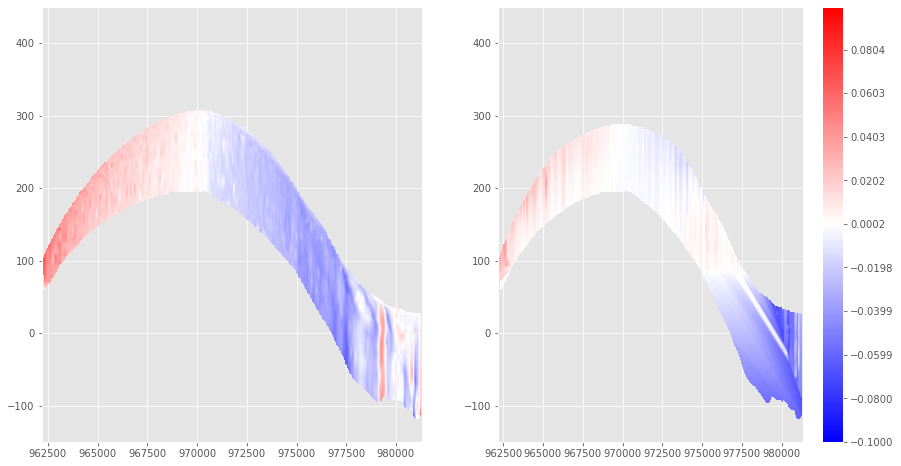

In [8]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x1'], Gridz['grid_z1'], Slopes['Slope1'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x1'], Gridz['grid_z1'], SlopesMod['Slope1'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/2990762887.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/2990762887.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


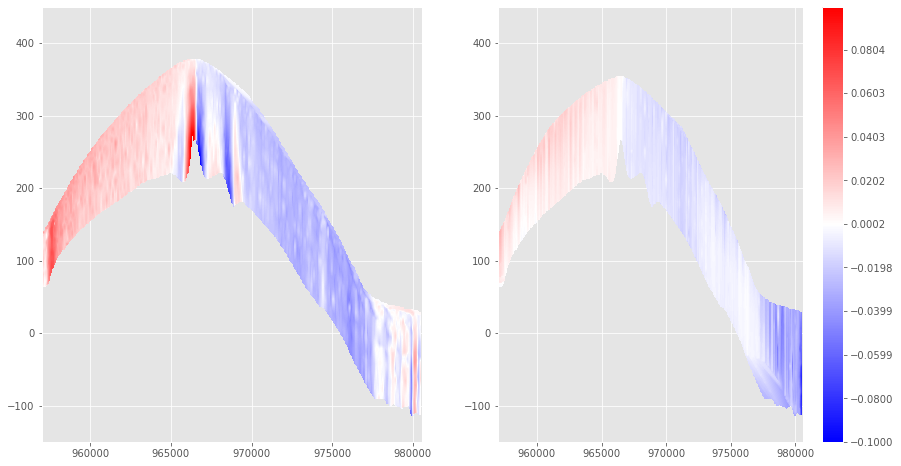

In [9]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x2'], Gridz['grid_z2'], Slopes['Slope2'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x2'], Gridz['grid_z2'], SlopesMod['Slope2'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1081837713.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1081837713.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


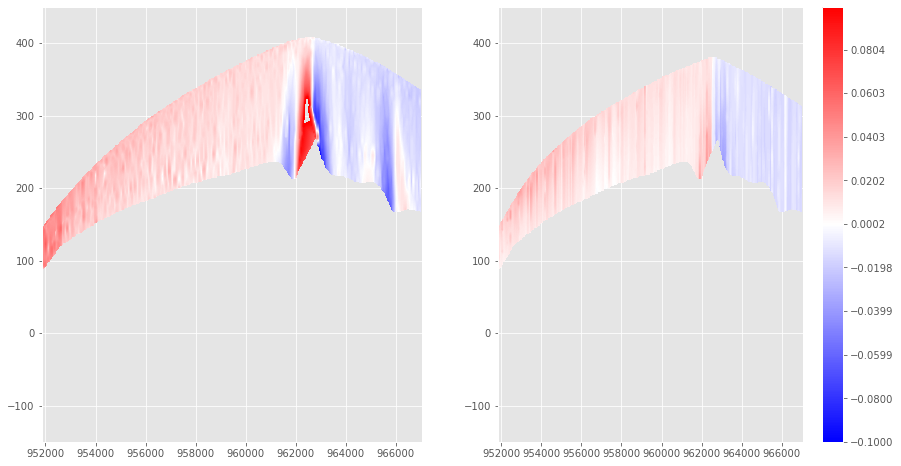

In [10]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x3'], Gridz['grid_z3'], Slopes['Slope3'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x3'], Gridz['grid_z3'], SlopesMod['Slope3'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1005515480.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1005515480.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


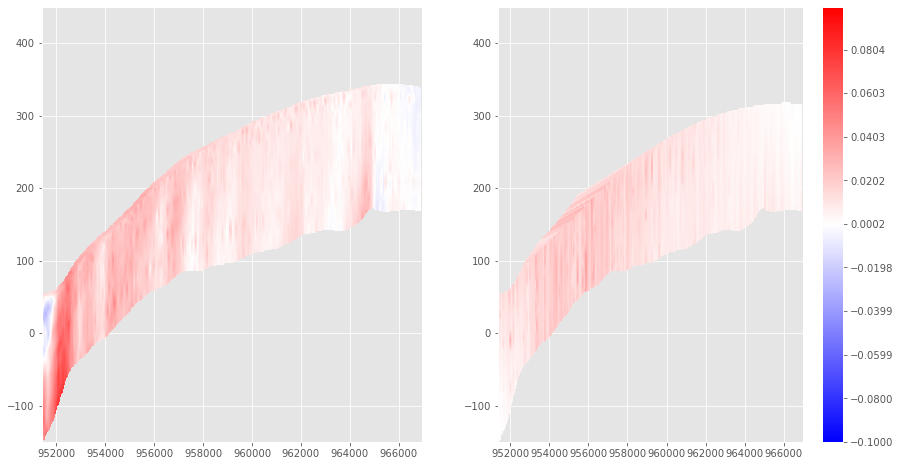

In [11]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x4'], Gridz['grid_z4'], Slopes['Slope4'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x4'], Gridz['grid_z4'], SlopesMod['Slope4'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/986913815.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/986913815.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


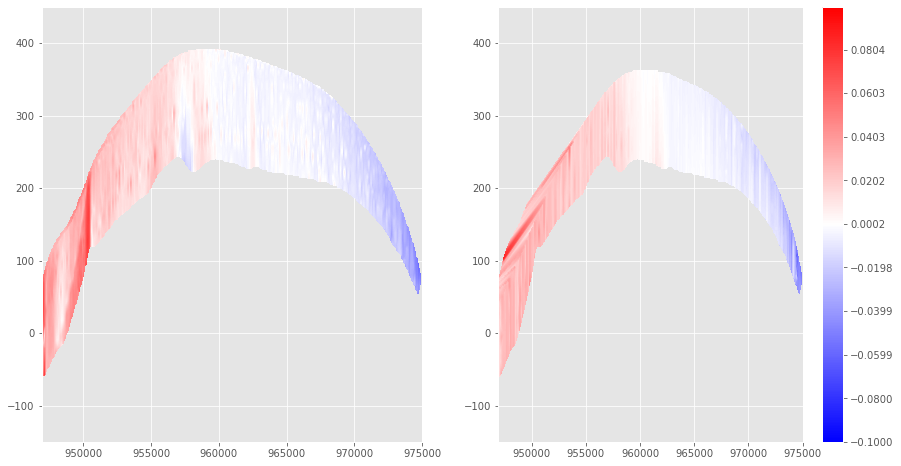

In [12]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x5'], Gridz['grid_z5'], Slopes['Slope5'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x5'], Gridz['grid_z5'], SlopesMod['Slope5'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1718749370.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/1718749370.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


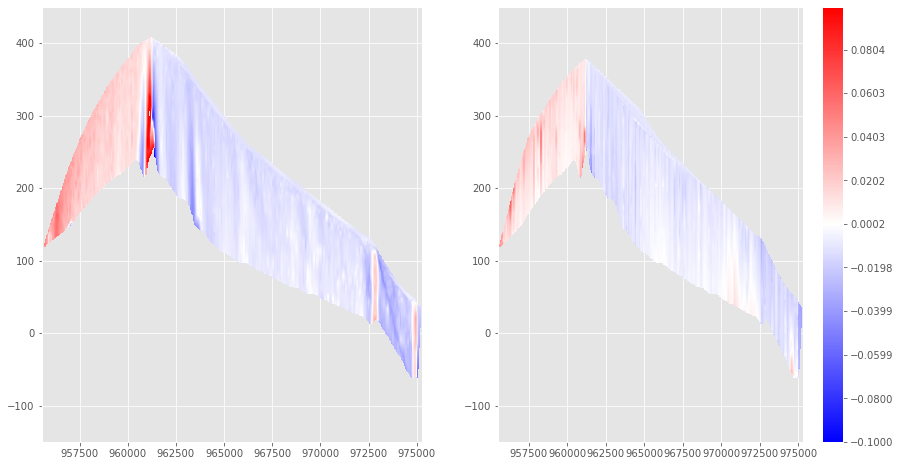

In [13]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x6'], Gridz['grid_z6'], Slopes['Slope6'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x6'], Gridz['grid_z6'], SlopesMod['Slope6'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/638302693.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(CS)
/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/638302693.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


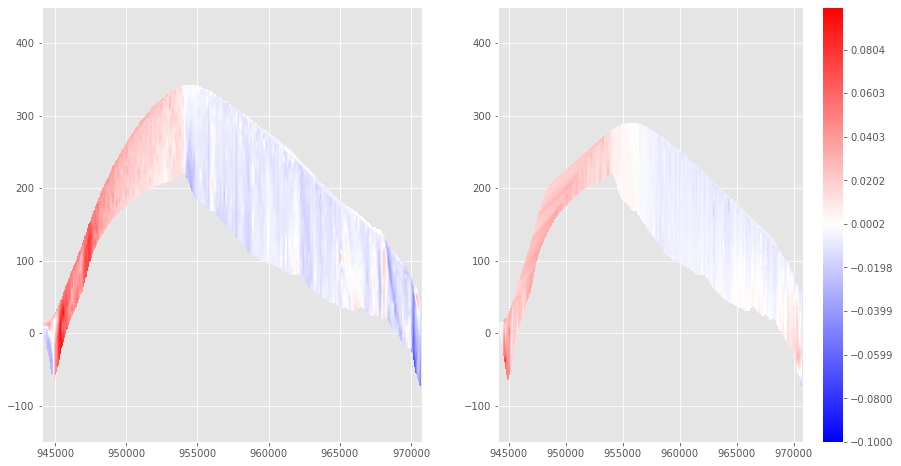

In [14]:
fig, ax = plt.subplots(1, 2, figsize=((15, 8)))
CS = ax[0].contourf(Gridx['grid_x7'], Gridz['grid_z7'], Slopes['Slope7'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
ax[1].contourf(Gridx['grid_x7'], Gridz['grid_z7'], SlopesMod['Slope7'], levels=np.linspace(-0.1,0.1,500), cmap='bwr', extend='both')
plt.colorbar(CS)

In [15]:
# Subtract the modelled stratigraphy from the observed stratigraphy

SlopesSubtraction = {}

for i in range(1,8):
    SlopesSubtraction['Slope' + str(i)] = Slopes['Slope' + str(i)] - SlopesMod['Slope' + str(i)]


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/3277085407.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


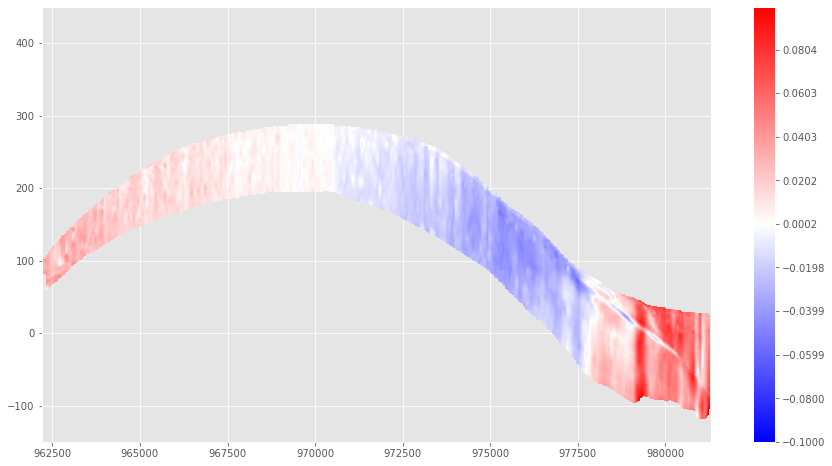

In [16]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x1'], Gridz['grid_z1'], SlopesSubtraction['Slope1'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/3700278380.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


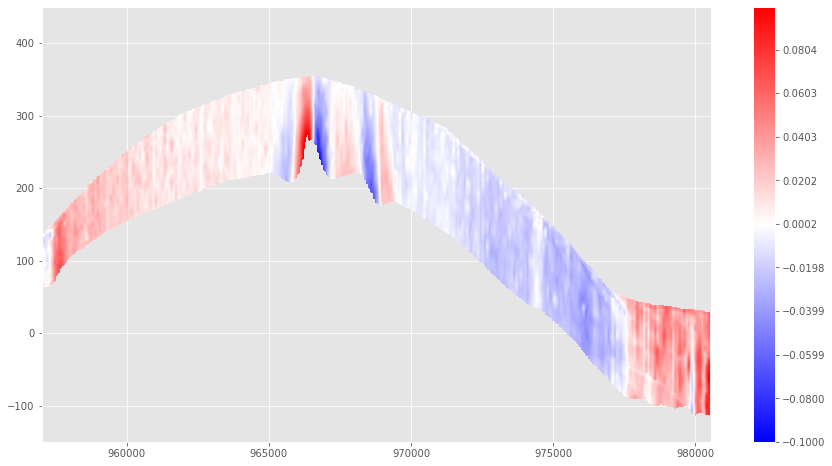

In [17]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x2'], Gridz['grid_z2'], SlopesSubtraction['Slope2'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/2393708672.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


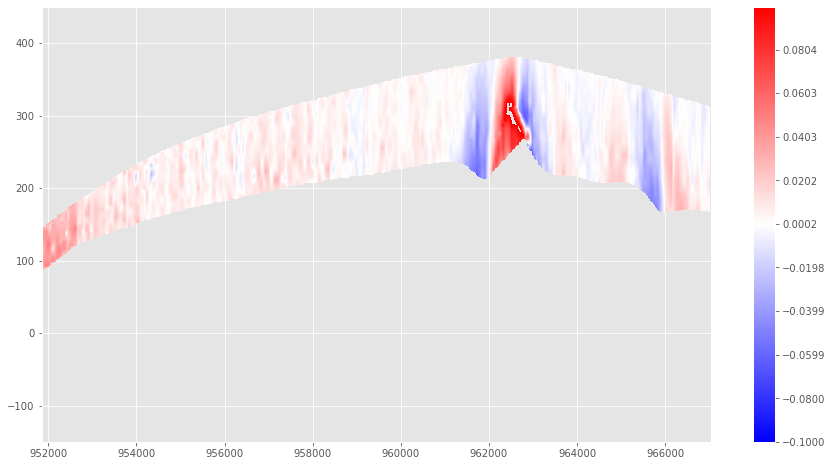

In [18]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x3'], Gridz['grid_z3'], SlopesSubtraction['Slope3'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/3243636518.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


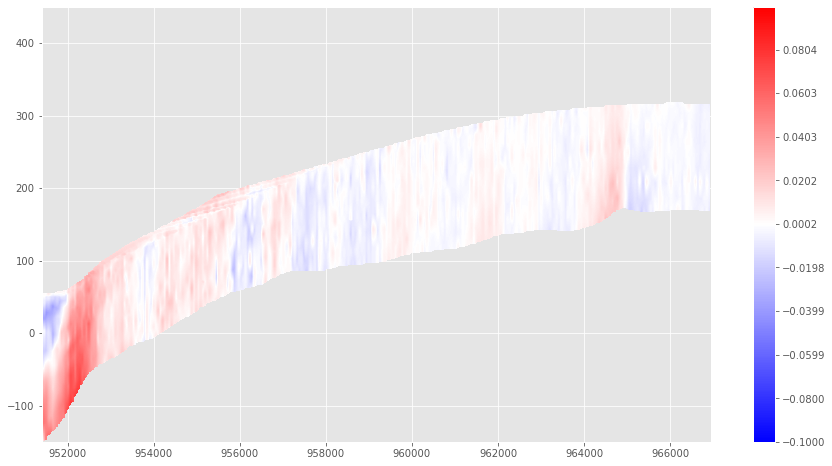

In [19]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x4'], Gridz['grid_z4'], SlopesSubtraction['Slope4'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/2220202855.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


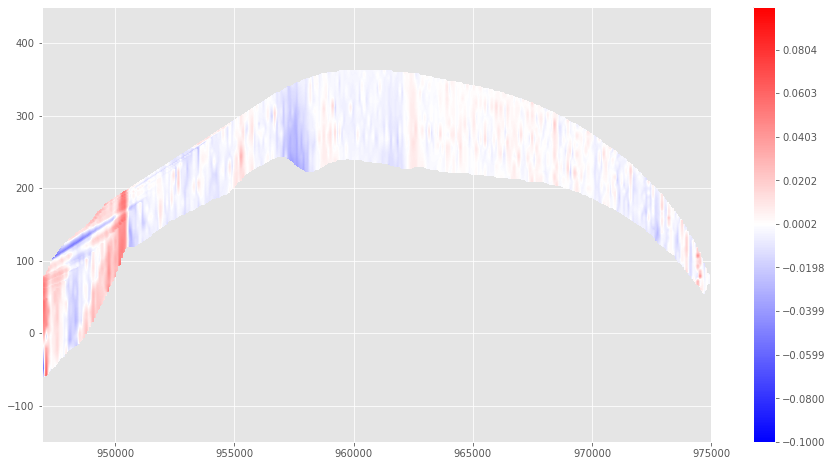

In [20]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x5'], Gridz['grid_z5'], SlopesSubtraction['Slope5'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/3922736250.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


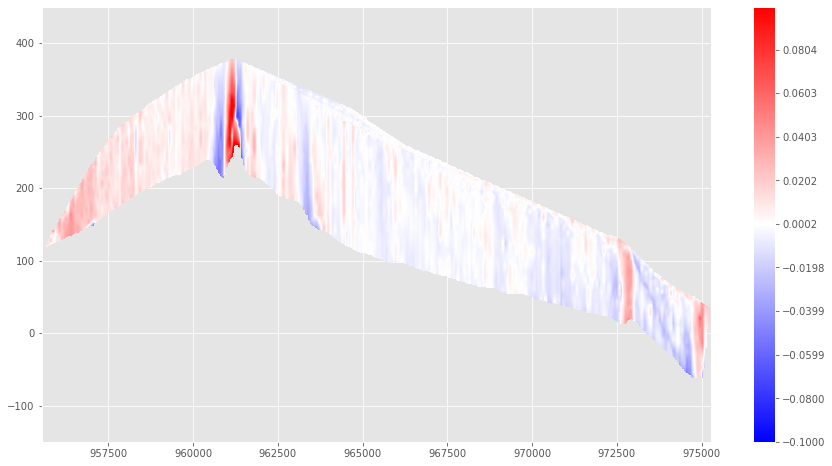

In [21]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x6'], Gridz['grid_z6'], SlopesSubtraction['Slope6'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_31575/419790446.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(CS)


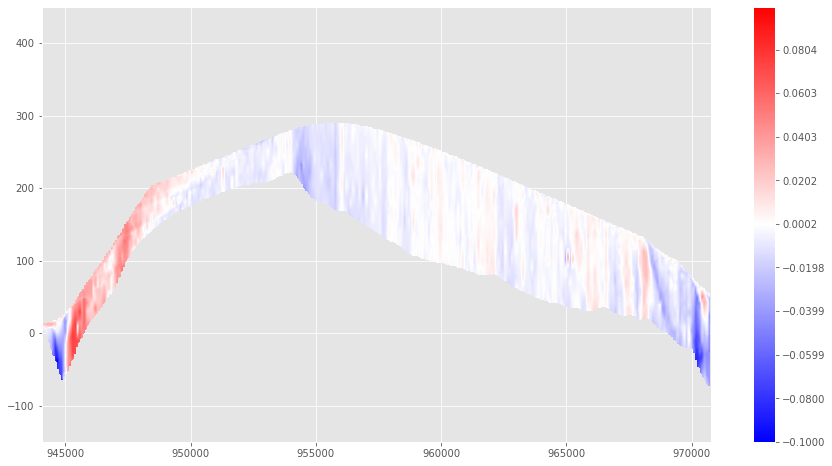

In [22]:
fig, ax = plt.subplots(1, 1, figsize=((15, 8)))
CS = ax.contourf(Gridx['grid_x7'], Gridz['grid_z7'], SlopesSubtraction['Slope7'], levels=np.linspace(-0.1,0.1,500), cmap='bwr')
plt.colorbar(CS)


In [23]:
# Plot this in the background of the isochrone figures and a small panel above showing
# the average slope difference




